# Progetto Corò Elia

In [1]:
# import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.semi_supervised import LabelPropagation
from utils.print_correlation_matrix import PrintCorrelationMatrix

from cleaning.fill_missing_values import fill_missing_values
from cleaning.remove_high_missing_fields import remove_high_missing_fields
from cleaning.remove_high_missing_columns import remove_high_missing_columns
from cleaning.one_hot_encoder import OneHotEncoderFunction


## Data Initial Cleaning

In [2]:
def pre_processing(data):
    # Mantieni solo le colonne presenti nel set di test
    # Questa operazione potrebbe rimuovere colonne se 'train.csv' ha colonne extra
    test_columns = list(pd.read_csv('test.csv').columns) + ['sii']
    data = data[test_columns]
    
    # Rimuovi la colonna 'id'
    data = data.drop(columns=['id'])
    
    # Rimuovi tutte le colonne season
    season_col = [col for col in data.columns if 'Season' in col]
    data = data.drop(columns=season_col)
    print(f"Colonne season rimosse: {len(season_col)}")
    
    # Rimuovi colonne con più dell'80% di valori mancanti
    data, removed_columns = remove_high_missing_columns(data, threshold=0.80)
    print(f"Colonne rimosse: {len(removed_columns)}")
    
    # Separa le righe con 'sii' mancante senza rimuoverle
    data_with_sii = data[data['sii'].notna()]
    data_without_sii = data[data['sii'].isna()]
    
    # Rimuovi righe con più dell'80% di valori mancanti nel sottoinsieme con 'sii' valido
    clean_data, removed_rows = remove_high_missing_fields(data_with_sii, threshold=0.8)
    print(f"Righe rimosse: {len(removed_rows)}")
    
    # Ricombina i dati
    data = pd.concat([clean_data, data_without_sii], ignore_index=True)
    
    # Controlla i valori mancanti in 'sii'
    missing_sii_count = data['sii'].isnull().sum()
    print(f"Numero di righe con 'sii' null: {missing_sii_count}")
    return data
    
# Carica i dati
data = pd.read_csv('train.csv')

data = pre_processing(data)
data


Colonne season rimosse: 10
Colonne rimosse: 4
Righe rimosse: 179
Numero di righe con 'sii' null: 1224


,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,...,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,3.0,2.0
1,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,...,21.0352,14.97400,39.4497,15.4107,27.0552,2.340,46.0,64.0,0.0,0.0
2,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,...,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0
3,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,...,30.4041,16.77900,58.9338,26.4798,45.9966,2.451,31.0,45.0,0.0,1.0
4,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,...,32.9141,20.90200,79.6982,35.3804,63.1265,4.110,40.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.880,NaN,NaN,NaN,NaN
3777,15,1,NaN,22.457960,62.0,122.8,30.0,64.0,60.0,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,49.0,68.0,2.0,NaN
3778,9,0,NaN,20.200490,52.5,79.2,28.0,75.0,92.0,142.0,...,NaN,NaN,NaN,NaN,NaN,1.990,NaN,NaN,0.0,NaN
3779,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,118.0,...,NaN,NaN,NaN,NaN,NaN,2.340,NaN,NaN,0.0,NaN


In [3]:
def standardize_dataframe(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_columns = [col for col in numeric_columns if col != 'sii']

    # Mantieni i valori originali di 'sii'
    sii_original = df['sii'].copy()

    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    # Ripristina i valori nulli di 'sii'
    df['sii'] = sii_original

    return df


data = standardize_dataframe(data)
data

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,-1.526353,-0.769415,-0.629012,-0.479691,-1.331150,-0.888673,NaN,NaN,NaN,NaN,...,-0.155328,-0.158518,-0.261175,-0.176702,-0.164755,NaN,NaN,NaN,1.763790,2.0
1,-0.403454,-0.769415,NaN,-1.035333,-1.063528,-0.997886,-0.948186,0.393202,-0.848813,0.294104,...,-0.215758,-0.071925,-0.256280,-0.225858,-0.208332,-0.322339,0.458747,0.461241,-0.972975,0.0
2,-0.122729,1.299688,0.246769,-0.524393,0.073864,-0.324405,NaN,-0.341610,0.907770,0.000992,...,NaN,NaN,NaN,NaN,NaN,-0.541082,-0.302422,-0.291112,0.851535,0.0
3,-0.403454,-0.769415,0.246769,-0.203011,0.006958,-0.187889,NaN,-0.709017,1.127343,0.000992,...,-0.049224,-0.046212,-0.076998,-0.094130,-0.061874,-0.179513,-0.968444,-0.968230,-0.972975,1.0
4,0.719445,1.299688,-0.672801,0.576685,0.475296,0.508346,NaN,-0.709017,-0.629240,-0.878343,...,-0.004609,0.012522,0.114064,0.011793,0.070577,1.955158,-0.112129,-0.140641,-0.972975,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,0.719445,-0.769415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.914232,NaN,NaN,NaN,NaN
3777,1.280895,1.299688,NaN,0.611490,0.809823,0.749525,0.488781,-0.415092,-1.580722,-0.643854,...,NaN,NaN,NaN,NaN,NaN,NaN,0.744185,0.762183,0.851535,NaN
3778,-0.403454,-0.769415,NaN,0.170088,-0.461380,-0.242495,0.129539,0.393202,0.761388,1.466551,...,NaN,NaN,NaN,NaN,NaN,-0.772692,NaN,NaN,-0.972975,NaN
3779,-0.122729,-0.769415,NaN,-0.110656,-0.327569,-0.306203,-0.050082,-0.709017,-0.263285,0.059615,...,NaN,NaN,NaN,NaN,NaN,-0.322339,NaN,NaN,-0.972975,NaN


In [4]:
data = OneHotEncoderFunction(data, ['sii'])
data

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,Physical-Diastolic_BP,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,Physical-Waist_Circumference,Physical-Weight,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_Raw,SDS-SDS_Total_T,sii
0,-0.633683,-0.043768,-0.492977,-0.162679,-0.201970,-0.171600,-0.162679,-0.209436,-0.200646,-0.038336,...,NaN,NaN,-1.331150,NaN,NaN,-0.888673,1.763790,NaN,NaN,2.0
1,-0.633683,-0.044730,-1.056150,-0.160457,-0.199625,-0.202128,-0.160458,-0.380787,-0.491718,-0.064640,...,0.393202,-0.848813,-1.063528,0.294104,-0.948186,-0.997886,-0.972975,0.458747,0.461241,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.341610,0.907770,0.073864,0.000992,NaN,-0.324405,0.851535,-0.302422,-0.291112,0.0
3,0.339072,-0.031091,-0.212569,-0.056407,-0.049816,-0.071440,-0.056404,-0.165178,-0.018280,0.009880,...,-0.709017,1.127343,0.006958,0.000992,NaN,-0.187889,-0.972975,-0.968444,-0.968230,1.0
4,-0.633683,-0.025814,2.143918,0.050190,-0.024067,0.128155,0.050189,0.286156,1.441792,0.256452,...,-0.709017,-0.629240,0.475296,-0.878343,NaN,0.508346,-0.972975,-0.112129,-0.140641,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.415092,-1.580722,0.809823,-0.643854,0.488781,0.749525,0.851535,0.744185,0.762183,NaN
3778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.393202,0.761388,-0.461380,1.466551,0.129539,-0.242495,-0.972975,NaN,NaN,NaN
3779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.709017,-0.263285,-0.327569,0.059615,-0.050082,-0.306203,-0.972975,NaN,NaN,NaN


In [5]:
y = data['sii']
X = data.drop('sii', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
X_train_filled = fill_missing_values(X_train)
X_test_filled = fill_missing_values(X_test)

/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
# Leggi i file CSV e assegna le variabili
X_train = X_train_filled
X_test = X_test_filled


In [8]:
def fill_y_column(X, y_column):
    # Sostituisci i valori NaN con -1 in y_train
    y_column_filled = y_column.copy()
    y_column_filled = y_column_filled.fillna(-1)

    # Crea e addestra il modello di Label Propagation
    lp = LabelPropagation(kernel='rbf', n_neighbors=5, max_iter=100)
    lp.fit(X, y_column_filled)
    
    # Predici i valori mancanti
    y_pred = lp.predict(X)
    
    # Sostituisci i valori predetti dove c'erano NaN
    y_column_imputed = y_column.copy()
    y_column_imputed[np.isnan(y_column)] = y_pred[np.isnan(y_column)]
    
    # Ora y_train_imputed contiene i valori originali e quelli riempiti tramite Label Propagation
    return y_column_imputed

y_train = fill_y_column(X_train, y_train)
y_test = fill_y_column(X_test, y_test)

/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:322: ConvergenceWarning: max_iter=100 was reached without convergence.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


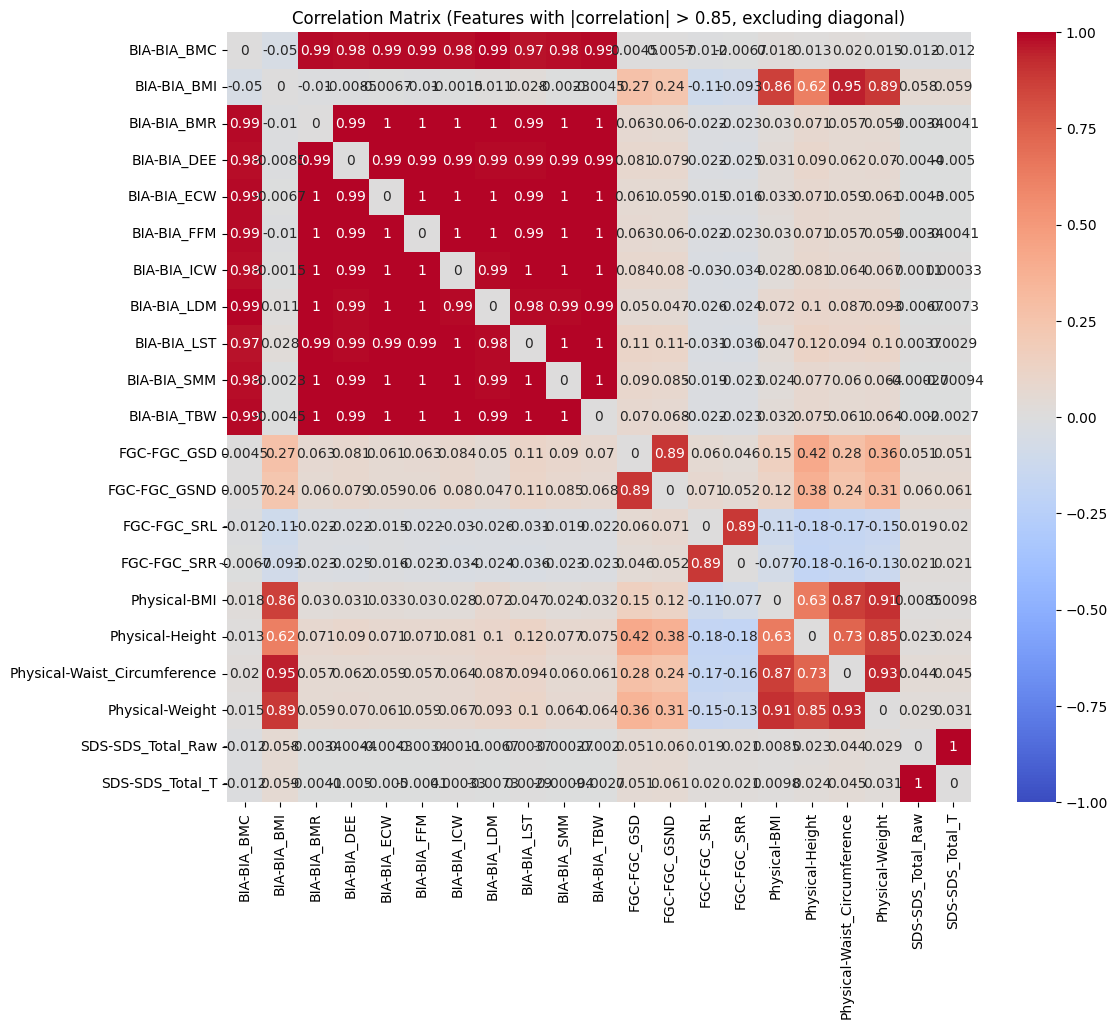

In [9]:
PrintCorrelationMatrix(X_train, 0.85)

Bia + Physical BMI provarle tutte e vedere la migliore
FGC-FGC_SRL, FGC-FGC_SRR prendere la media
togliere FGC-FGC_SRL_Zone
prendere SDS-SDS_Total_T ed escludere SDS-SDS_Total_Raw
Tutte le colonne PreInt_EduHx-Season le togliamo, sono colonne che indicano quando sono stati raccolti dati di interesse, ma di per sè sapere quando questi vengono raccolti non ce ne ciava un cazzo :)



In [10]:
def data_cleaning(df):
    # Per le seguenti colonne teniamo solo BIA-BIA_BMI
    to_remove = ['BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_ICW', 'BIA-BIA_FFM',
                 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']
    # Elimina le colonne non necessarie
    df = df.drop(columns=[col for col in to_remove if col in df.columns])

    # Tra Physical-Waist_Circumference, Physical-Weight e Physical-BMI teniamo l'ultima
    to_remove = ['Physical-Waist_Circumference', 'Physical-Weight']
    df = df.drop(columns=[col for col in to_remove if col in df.columns])
    
    # Calcola la media tra 'FGC-FGC_SRL' e 'FGC-FGC_SRR'
    # FGC-FGC_SRL -> Forza di presa della mano dominante (misurata con un dinamometro)
    # FGC-FGC_SRR -> Forza di presa della mano non dominante (misurata con un dinamometro)
    if {'FGC-FGC_SRL', 'FGC-FGC_SRR'}.issubset(df.columns) and 'FGC-FGC_SRM' not in df.columns:
        df['FGC-FGC_SRM'] = (df['FGC-FGC_SRL'] + df['FGC-FGC_SRR']) / 2
        df = df.drop(columns=['FGC-FGC_SRL', 'FGC-FGC_SRR'])

    # Calcola la media tra 'FGC-FGC_GSD' e 'FGC-FGC_GSND'
    # FGC-FGC_GSD -> Forza di presa della mano dominante (misurata specificamente per la forza)
    # FGC-FGC_GSND -> Forza di presa della mano non dominante (misurata specificamente per la forza)
    if {'FGC-FGC_GSD', 'FGC-FGC_GSND'}.issubset(df.columns) and 'FGC-FGC_GSM' not in df.columns:
        df['FGC-FGC_GSM'] = (df['FGC-FGC_GSD'] + df['FGC-FGC_GSND']) / 2
        df = df.drop(columns=['FGC-FGC_GSD', 'FGC-FGC_GSND'])

    # Rimuovi tutte le colonne _Zone, sono delle categorizzazioni di altre colonne
    zone_col = [col for col in df.columns if '_Zone' in col]
    df = df.drop(columns=zone_col)
    print(f"Colonne _Zone rimosse: {zone_col}")

    # Mantieni solo 'SDS-SDS_Total_T' e rimuovi 'SDS-SDS_Total_Raw'
    # SDS-SDS_Total_T -> Punteggio T totale della scala di disturbi del sonno (punteggio standardizzato per la qualità del sonno)
    if 'SDS-SDS_Total_Raw' in df.columns:
        df = df.drop(columns=['SDS-SDS_Total_Raw'])

    # Tra BIA-BIA_BMI e Physical-BMI teniamo solo Physical-BMI
    # BIA-BIA_BMI -> valore calcolato sulla base del peso e dell'altezza
    # Physical-BMI -> misura ottenuta tramite macchinario
    to_remove = ['BIA-BIA_BMI']
    df = df.drop(columns=[col for col in to_remove if col in df.columns])

    # Rimuovi la colonna BIA-BIA_Fat
    # BIA-BIA_Fat -> Percentuale di grasso corporeo calcolata tramite analisi dell'impedenza bioelettrica (BIA).
    # BIA-BIA_FMI -> Indice di massa grassa calcolato dividendo la massa grassa per l'altezza al quadrato del partecipante
    # Rimuoviamo BIA-BIA_Fat e teniamo la versione normalizzata
    if 'BIA-BIA_Fat' in df.columns:
        df = df.drop(columns=['BIA-BIA_Fat'])

    return df

X_train = data_cleaning(X_train)
X_test = data_cleaning(X_test)


Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']
Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']


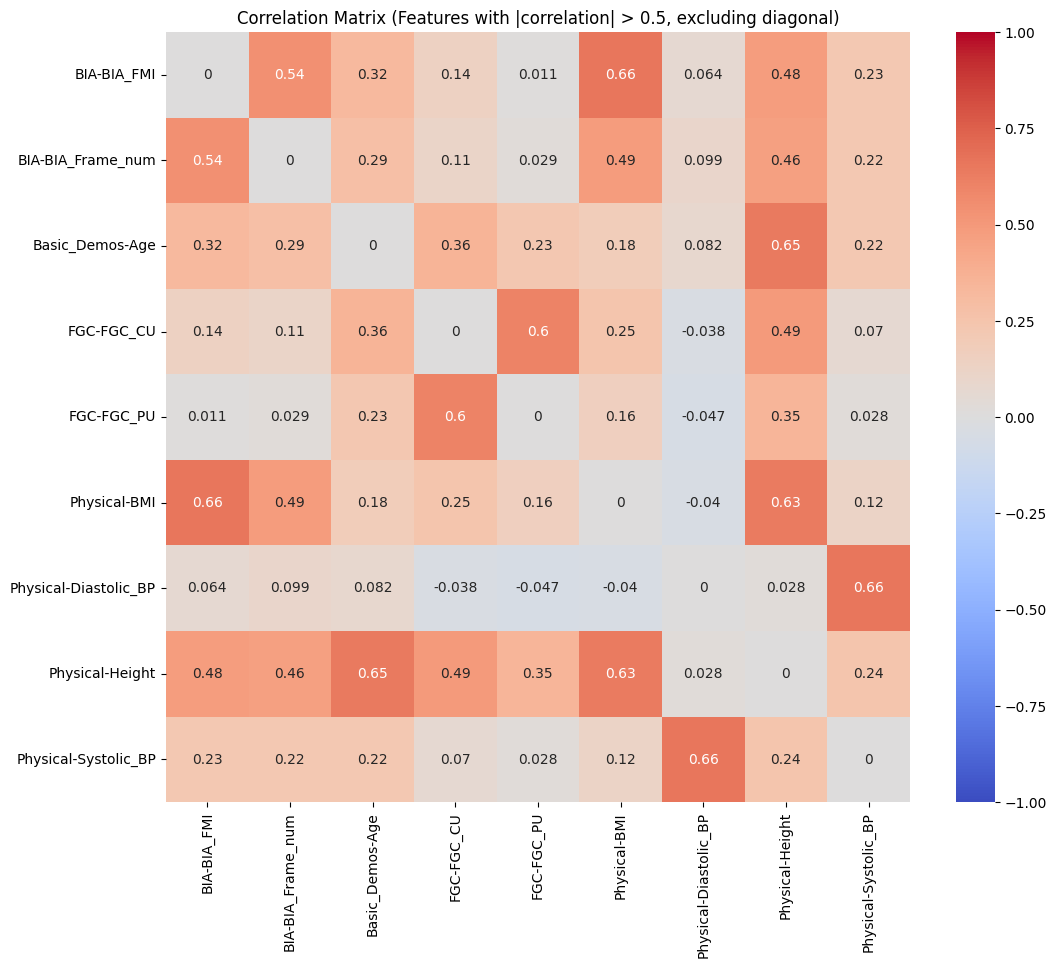

In [11]:
PrintCorrelationMatrix(X_train, 0.50)

In [12]:
X_train

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Frame_num,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,FGC-FGC_CU,FGC-FGC_PU,...,PAQ_C-PAQ_C_Total,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_T,FGC-FGC_SRM,FGC-FGC_GSM
1304,0.339072,0.002874,0.521796,0.074146,0.374224,2.123069,-0.769415,0.008557,1.163916,4.523255,...,0.812163,0.689606,0.393202,-1.214767,1.746498,0.059615,0.851535,0.085065,-0.803325,0.849568
2933,0.066700,-0.046151,-0.240756,-0.371772,-0.331177,0.719445,1.299688,-0.135509,-0.688651,-0.696976,...,-0.392466,-0.750101,0.032409,0.219043,-0.283585,-0.173702,-0.224926,0.310771,0.344638,-0.134438
3742,-1.606437,-0.035310,0.109677,0.363028,0.374224,-0.122729,-0.769415,-0.258557,-0.953788,-0.755175,...,-0.566817,0.581921,-0.121167,0.761388,-0.528285,0.880328,-0.972975,0.085065,-2.554852,-2.090446
3368,0.183431,-0.052187,-0.305226,-0.485358,-0.463440,-0.684179,-0.769415,0.056725,-0.607331,-0.636072,...,-0.330549,-3.684941,0.375566,0.814817,-1.031373,0.027959,0.851535,0.085065,-0.365601,-0.142420
3213,1.311826,-0.049291,-0.062951,-0.365988,1.843810,-1.245628,-0.769415,-0.103981,-0.469257,-0.642839,...,-0.038103,-0.518950,0.099277,1.786061,-1.498413,0.763083,0.249447,-0.291112,-0.233940,-0.255646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,0.241796,-0.021545,0.020905,0.408099,0.447703,0.157996,1.299688,1.078761,1.587457,2.222401,...,0.835710,0.488503,1.348457,3.030307,0.776370,1.759663,-0.060720,-0.366347,0.364866,0.140312
750,0.339072,-0.029721,0.268785,0.790148,1.843810,0.438721,1.299688,-0.234910,-0.106706,0.733613,...,-0.167933,1.292727,-0.929460,-0.629240,0.073864,-0.585231,0.851535,0.085065,1.241086,-0.652133
1140,0.125066,-0.026445,0.083028,0.162420,0.095003,-0.122729,1.299688,0.202980,-0.740323,-0.665847,...,-1.274514,0.293015,1.128014,0.907770,-0.294116,0.938950,-0.972975,-0.667288,-0.329392,-0.034538
2829,0.193158,-0.051776,-0.284016,-0.460606,-0.463440,-0.684179,-0.769415,-0.264249,-0.106706,1.004302,...,1.513684,-3.678394,0.333682,-0.018827,-1.504020,0.180377,-0.972975,0.085065,0.218728,0.132267


## Data preparation

In [13]:
from cleaning.rfecv_selection import rfecv_selection

column_number, selected_features = rfecv_selection(X_train, y_train)

# Mostra il numero delle feature selezionate
print(f"Numero di feature selezionate: {column_number}")

# Mostra le feature selezionate
print(f"Feature selezionate: {selected_features}")


Numero di feature selezionate: 21
Feature selezionate: ['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Frame_num', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 'PAQ_C-PAQ_C_Total', 'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height', 'Physical-Systolic_BP', 'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'FGC-FGC_SRM', 'FGC-FGC_GSM']


In [14]:
from cleaning.rfe_selection import rfe_selection

column = rfe_selection(X_train, y_train, column_number)

data = pd.concat([X_train[column], y_train], axis=1)
column
# Sia RFECV che RFE hanno restituito le features nello stesso ordine

Index(['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_FFMI',
       'BIA-BIA_FMI', 'BIA-BIA_Frame_num', 'Basic_Demos-Age',
       'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_PU',
       'FGC-FGC_TL', 'PAQ_C-PAQ_C_Total', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height',
       'Physical-Systolic_BP', 'PreInt_EduHx-computerinternet_hoursday',
       'SDS-SDS_Total_T', 'FGC-FGC_SRM', 'FGC-FGC_GSM'],
      dtype='object')

In [15]:
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

print("Distribuzione delle etichette nel training set:")
print(train_counts)

print("Distribuzione delle etichette nel test set:")
print(test_counts)


Distribuzione delle etichette nel training set:
sii
0.0    1829
1.0     731
2.0     438
3.0      26
Name: count, dtype: int64
Distribuzione delle etichette nel test set:
sii
0.0    395
1.0    265
2.0     84
3.0     13
Name: count, dtype: int64


In [16]:
# Il dataset è fortemente sbilanciato
# Come metrica per la valutazione dei modelli usiamo una media ponderata in base alla proporzione inversa 
# della quantità di classi, in modo che anche se una classe ha poche istanze tenterà di ottenere una media generale buona

# utilizziamo class_weight="balanced"

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer

def grid_search_rf(X_train, y_train):
    model = RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced"
    )

    param_grid = {
        'max_depth': [10, 20, 40, 60, 80, 100, 150],
        'min_samples_leaf': [1, 2, 3, 4, 5]
    }

    # Usa la balanced_accuracy_score come metrica
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=10
    )

    # Esegui la ricerca
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    return best_params

# Esegui il grid search
parameters = grid_search_rf(X_train, y_train)


Best parameters: {'max_depth': 150, 'min_samples_leaf': 1}


Train Accuracy: 1.0000
Test Accuracy: 0.5244
Train Balanced Accuracy: 1.0000
Test Balanced Accuracy: 0.2777


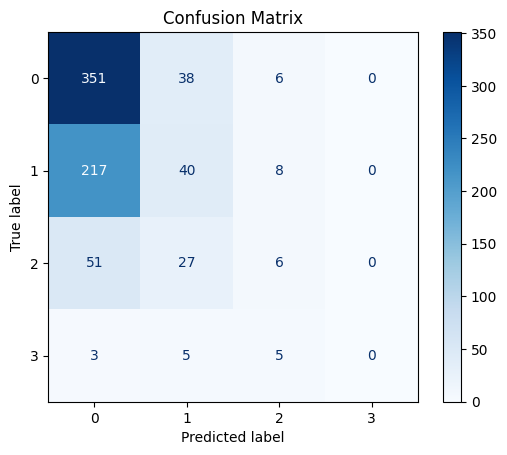

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from utils.print_confusion_matrix import print_confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import plot_tree

model = RandomForestClassifier(**parameters)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test[X_train.columns])

# Calcola l'accuracy per il training e il test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calcola la balanced accuracy per il training e il test
train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)

# Stampa i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

print_confusion_matrix(y_test, y_test_pred)

In [19]:
# rimane una forte predominanza per la feature con classe 0
# Proviamo con un modello ANN
from tensorflow.keras.utils import to_categorical

y_train_categorial = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_categorial = to_categorical(y_test, num_classes=len(np.unique(y_train)))


2025-01-25 16:30:40.535808: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 16:30:40.536385: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 16:30:40.538582: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 16:30:40.542927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737819040.549469  776792 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737819040.55

In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score
from itertools import product

# Funzione per calcolare la balanced accuracy
def balanced_accuracy(y_true, y_pred):
    # Calcola la frequenza di ciascuna classe nel dataset
    class_counts = np.bincount(y_true)
    total_samples = len(y_true)
    
    # Calcola la frequenza inversa di ciascuna classe
    class_weights = total_samples / class_counts
    class_weights = class_weights / np.sum(class_weights)  # Normalizza i pesi per fare una somma di 1

    # Crea il parametro sample_weight in base alla classe di ogni campione
    sample_weights = class_weights[y_true]

    # Calcola la balanced accuracy utilizzando i pesi
    acc = balanced_accuracy_score(y_true, y_pred, sample_weight=sample_weights)
    
    return acc


# Funzione per creare il modello
def create_model(X_train, y_train, n_neurons=64, hidden_layer=1, dropout=True, activation='relu'):
    if hidden_layer < 1:
        raise ValueError("There should be at least one hidden layer")

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    for _ in range(hidden_layer):
        model.add(Dense(n_neurons, activation=activation))
        if dropout:
            model.add(Dropout(0.25))

    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [34]:
import itertools

# Definisci i pesi per ogni classe
weights_per_class = {
    0: [0.5, 0.8],
    1: [0.5, 0.8, 1],
    2: [1.5, 2],
    3: [1.5, 2]
}

# Crea una lista di tutte le combinazioni di pesi
weight_combinations = list(itertools.product(*weights_per_class.values()))

# Crea una funzione per ottenere i pesi per i campioni basata sulle combinazioni di pesi
def get_sample_weights(y, weight_combination, weights_per_class):
    sample_weights = np.zeros_like(y, dtype=float)
    for class_label, weight in zip(weights_per_class.keys(), weight_combination):
        class_indices = np.where(y == class_label)[0]
        sample_weights[class_indices] = weight
    return sample_weights

# Parametri da testare
n_neurons_options = [32, 64]
hidden_layer_options = [1, 3, 5, 10]
dropout_options = [True, False]

# Variabili per tracciare i migliori risultati
best_score = -np.inf
best_params = {}

# Make it faster ;)
n_neurons_options = [64]
hidden_layer_options = [5]
dropout_options = [True]
weight_combinations = [(0.5, 0.8, 1.5, 1.5)]

# Combinazione di tutte le possibili configurazioni di parametri
param_combinations = product(n_neurons_options, hidden_layer_options, dropout_options)

# Loop su ogni combinazione di parametri e pesi
for n_neurons, hidden_layer, dropout in param_combinations:
    for weight_combination in weight_combinations:
        print(f"Training with {n_neurons} neurons, {hidden_layer} hidden layers, dropout={dropout}")
        print(f"Using weight combination: {weight_combination}")

        # Ottieni i pesi per i campioni basati sulla combinazione corrente di pesi
        sample_weights = get_sample_weights(y_train, weight_combination, weights_per_class)

        # Crea il modello con i parametri correnti
        model = create_model(X_train, y_train, n_neurons=n_neurons, hidden_layer=hidden_layer, dropout=dropout)
        
        # Addestra il modello
        model.fit(
            X_train, 
            y_train_categorial, 
            epochs=10, 
            batch_size=128, 
            verbose=0, 
            sample_weight=sample_weights
        )

       # Previsioni e calcolo del punteggio per il training
        y_pred_train = model.predict(X_train)
        y_pred_train_numerical = np.argmax(y_pred_train, axis=1)  # Converti le previsioni one-hot in numeriche
        score_train = balanced_accuracy(np.argmax(y_train_categorial, axis=1), y_pred_train_numerical)
        
        # Previsioni e calcolo del punteggio per il test
        y_pred_test = model.predict(X_test)
        y_pred_test_numerical = np.argmax(y_pred_test, axis=1)  # Converti le previsioni one-hot in numeriche
        score_test = balanced_accuracy(np.argmax(y_test_categorial, axis=1), y_pred_test_numerical)



        print(f"Balanced Accuracy Train: {score_train}")
        print(f"Balanced Accuracy Test: {score_test}")

        # Se troviamo un punteggio migliore, aggiorniamo il migliore
        if score_test > best_score:
            best_score = score_test
            best_params = {
                'n_neurons': n_neurons,
                'hidden_layer': hidden_layer,
                'dropout': dropout,
                'weights': weight_combination
            }

# Stampa i migliori parametri e punteggio
print(f"Best parameters: {best_params}")
print(f"Best balanced accuracy score: {best_score}")


Training with 64 neurons, 5 hidden layers, dropout=True
Using weight combination: (0.5, 0.8, 1.5, 1.5)
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
Balanced Accuracy Train: 0.05326697246820835
Balanced Accuracy Test: 0.10544074235794443
Best parameters: {'n_neurons': 64, 'hidden_layer': 5, 'dropout': True, 'weights': (0.5, 0.8, 1.5, 1.5)}
Best balanced accuracy score: 0.10544074235794443


In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

def plot_ann(history):
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    if 'val_accuracy' in history.history:  # Correct key for validation accuracy
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Accuracy During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


model = create_model(
    X_train, 
    y_train, 
    n_neurons=best_params['n_neurons'], 
    hidden_layer=best_params['hidden_layer'], 
    dropout=best_params['dropout'])

early_stopping = EarlyStopping(patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    verbose=1
)

# train the network
history = model.fit( x=X_train, # training examples
           y=y_train_categorial, # desired output
           epochs=35,
           verbose=1,
           validation_data=(X_test, y_test_categorial),
           class_weight={i: best_params['weights'][i] for i in range(len(best_params['weights']))},
           callbacks=[lr_scheduler, early_stopping]);

Epoch 1/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4797 - loss: 0.8724 - val_accuracy: 0.4373 - val_loss: 1.0592 - learning_rate: 0.0010
Epoch 2/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.5589 - loss: 0.7784 - val_accuracy: 0.4795 - val_loss: 1.0288 - learning_rate: 0.0010
Epoch 3/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.5804 - loss: 0.7460 - val_accuracy: 0.4637 - val_loss: 1.0432 - learning_rate: 0.0010
Epoch 4/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.5827 - loss: 0.7414 - val_accuracy: 0.4835 - val_loss: 1.0357 - learning_rate: 0.0010
Epoch 5/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.6011 - loss: 0.7153 - val_accuracy: 0.4782 - val_loss: 1.0429 - learning_rate: 0.0010
Epoch 6/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.6037 - loss: 0.6970 - val_accuracy: 0.4703 - val_loss: 1.0706 - learning_rate: 0.0010
Epoch 7/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.6118 - loss: 0.6927 - va

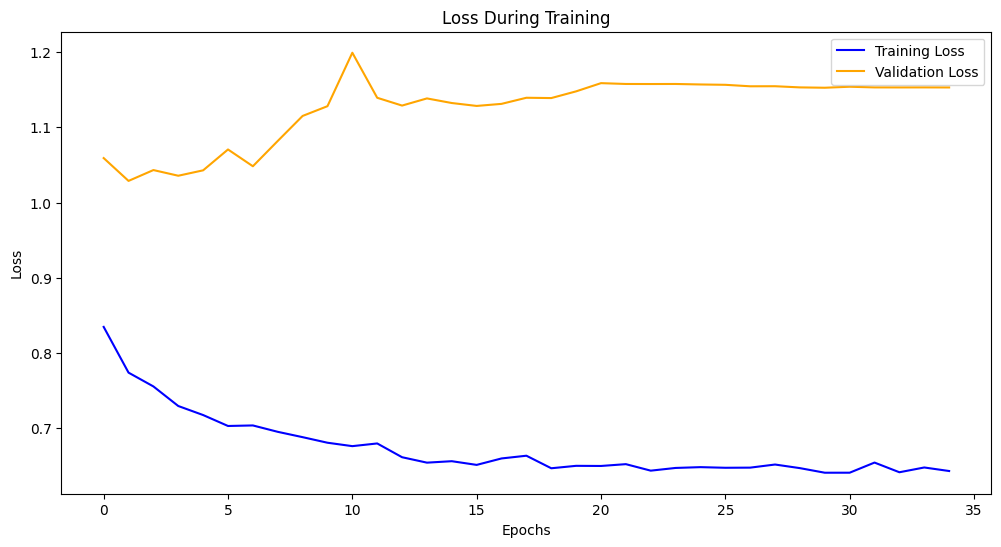

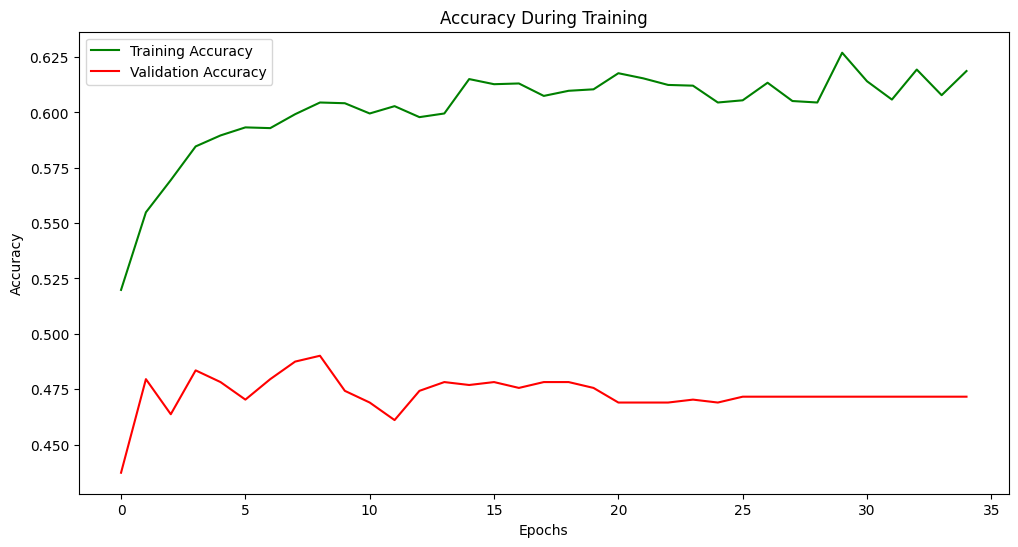

In [36]:
plot_ann(history)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
Train Accuracy: 0.6118
Test Accuracy: 0.4795
Train Balanced Accuracy: 0.3926
Test Balanced Accuracy: 0.3469


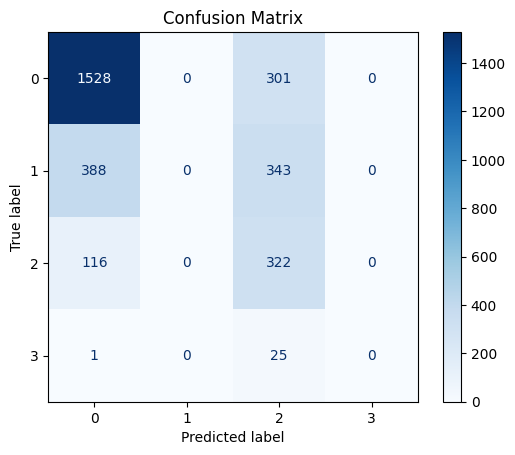

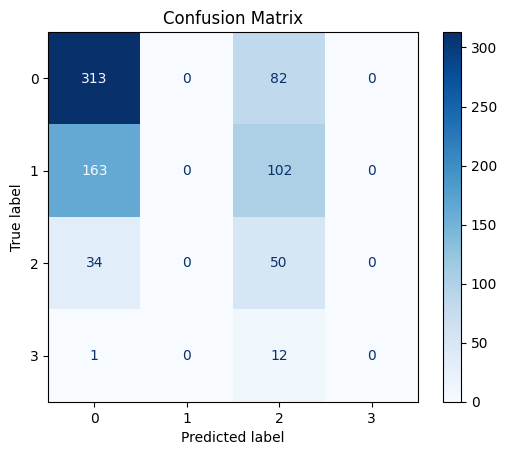

In [38]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test[X_train.columns])

# Converti le probabilità in etichette discrete (classi)
y_train_pred_label = np.argmax(y_train_pred, axis=1)
y_test_pred_label = np.argmax(y_test_pred, axis=1)

# Calcola l'accuracy per il training e il test
train_accuracy = accuracy_score(y_train, y_train_pred_label)
test_accuracy = accuracy_score(y_test, y_test_pred_label)

# Calcola la balanced accuracy per il training e il test
train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred_label)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred_label)

# Stampa i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

# Stampa la matrice di confusione
print_confusion_matrix(y_train, y_train_pred_label)
print_confusion_matrix(y_test, y_test_pred_label)


In [39]:
# Meglio rispetto alla random forest

## LightGBM

In [40]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Reset data
# Carica i dati
data = pd.read_csv('train.csv')

data = pre_processing(data)
data = standardize_dataframe(data)

# Gestisce automaticamente nel caso in cui la X sia Null, ma non la y, proviamo inizialmente ad eliminare quelle righe
data = data.dropna(subset=['sii'])

X = data.drop(columns=['sii'])
y = data['sii']

# OneHotEncoding is not required

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# it's also capable of managed missing values


Colonne season rimosse: 10
Colonne rimosse: 4
Righe rimosse: 179
Numero di righe con 'sii' null: 1224


In [43]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Parametri base per LightGBM
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': len(y_train.unique()),
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Crea un dataset per LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Definizione dei parametri da ottimizzare
param_grid = {
    'num_leaves': [10, 50, 100],
    'max_depth': [5, 15],
    'learning_rate': [0.1],
    'n_estimators': [50, 75, 100],
    'subsample': [0.7],
    'colsample_bytree': [0.5]
}

# Impostare il modello LightGBM per la ricerca dei migliori iperparametri
model = lgb.LGBMClassifier(objective='multiclass', metric='multi_logloss', num_class=len(y_train.unique()))

# Esegui il grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0, n_jobs=-1)

# Addestra il modello con il grid search
grid_search.fit(X_train, y_train)

# I migliori parametri trovati
print("Best parameters found: ", grid_search.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5331
[LightGBM] [Info] Number of data points in the train set: 1363, number of used features: 44
[LightGBM] [Info] Start training from score -0.531582
[LightGBM] [Info] Start training from score -1.325799
[LightGBM] [Info] Start training from score -2.007957
[LightGBM] [Info] Start training from score -4.384230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [52]:
# Allena il modello con i parametri ottimizzati
best_model = grid_search.best_estimator_

# Fai delle previsioni sul test set
y_train_pred_prob = best_model.predict_proba(X_train)  # Ottieni probabilità se il modello restituisce probabilità
y_test_pred_prob = best_model.predict_proba(X_test)

# Se le predizioni sono probabilità, usa np.argmax per ottenere l'etichetta
y_train_pred_label = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_label = np.argmax(y_test_pred_prob, axis=1)

# Assicurati che le etichette siano intere
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Calcola l'accuratezza
accuracy = accuracy_score(y_test, y_test_pred_label)
print(f"Accuracy: {accuracy:.4f}")

# Eseguiamo la balanced accuracy per il training e il test set
train_balanced_accuracy = balanced_accuracy(y_train, y_train_pred_label)
test_balanced_accuracy = balanced_accuracy(y_test, y_test_pred_label)

print(f"Train Inverse Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Inverse Balanced Accuracy: {test_balanced_accuracy:.4f}")


Accuracy: 0.5840
Train Inverse Balanced Accuracy: 0.9996
Test Inverse Balanced Accuracy: 0.0452
